# Step 1: Import Libraries

In [75]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import plotly.graph_objects as go
import plotly.express as px

# Step 2: Load and Preprocess Data

In [76]:
# Paths to the dataset
dataset_path = "/Kuliah/Sem 7/PCD/Tubes/animals/animals"
labels_file = "/Kuliah/Sem 7/PCD/Tubes/animals/name of the animals.txt"

In [77]:
# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')

In [78]:
# Display the first few animal names
animal_names[:10]

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat']

# Explotratory data analysis

In [79]:
# Display distribution of animal classes
animal_counts = {animal: len(os.listdir(os.path.join(dataset_path, animal))) for animal in animal_names}
animal_counts_df = pd.DataFrame(list(animal_counts.items()), columns=['Animal', 'Count'])
animal_counts_df = animal_counts_df.sort_values(by='Count', ascending=False)

fig = px.bar(animal_counts_df, x='Animal', y='Count', title='Distribution of Animal Classes', 
             labels={'Animal': 'Animal', 'Count': 'Number of Images'},
             color='Count', color_continuous_scale='Viridis', template='plotly_dark')
fig.update_layout(title_font_size=24, title_x=0.5, xaxis_title_font_size=18, 
                 yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14))
fig.show()

In [80]:
class AnimalDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)  
            
        return image, label

In [81]:
# Image Preprocessing using OpenCV
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = (image / 255.0).astype(np.float32)  
    return image

In [82]:
# Create dataset
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

In [83]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [84]:
#Model Definition
class YOLOv9Classification(nn.Module):
    def __init__(self, num_classes):
        super(YOLOv9Classification, self).__init__()
        
        # Base features (similar to YOLOv9 backbone)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [85]:
# Data Preparation
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [86]:
# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [87]:
# Create datasets with the corrected transform
train_dataset = AnimalDataset(X_train, y_train, transform=transform)
test_dataset = AnimalDataset(X_test, y_test, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [88]:
# Model Training
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv9Classification(num_classes=len(animal_names)).to(device).float()

In [89]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

In [90]:
# Training loop
num_epochs = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0

In [91]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.float().to(device)  
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_acc = 100.0 * train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.0 * val_correct / val_total
    scheduler.step(val_loss)

    # Save metrics
    history['train_loss'].append(train_loss/len(train_loader))
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss/len(test_loader))
    history['val_acc'].append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss/len(test_loader):.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/10]
Train Loss: 4.2936, Train Acc: 4.24%
Val Loss: 4.0859, Val Acc: 5.74%
Epoch [2/10]
Train Loss: 4.0524, Train Acc: 6.37%
Val Loss: 4.0483, Val Acc: 7.22%
Epoch [3/10]
Train Loss: 3.9519, Train Acc: 7.69%
Val Loss: 3.9305, Val Acc: 7.96%
Epoch [4/10]
Train Loss: 3.8594, Train Acc: 9.51%
Val Loss: 3.8161, Val Acc: 10.46%
Epoch [5/10]
Train Loss: 3.7719, Train Acc: 10.69%
Val Loss: 3.7875, Val Acc: 11.57%
Epoch [6/10]
Train Loss: 3.7137, Train Acc: 12.11%
Val Loss: 3.7172, Val Acc: 12.50%
Epoch [7/10]
Train Loss: 3.6122, Train Acc: 13.73%
Val Loss: 3.6336, Val Acc: 14.17%
Epoch [8/10]
Train Loss: 3.5695, Train Acc: 14.81%
Val Loss: 3.6141, Val Acc: 13.98%
Epoch [9/10]
Train Loss: 3.5008, Train Acc: 15.21%
Val Loss: 3.5909, Val Acc: 14.91%
Epoch [10/10]
Train Loss: 3.4449, Train Acc: 16.00%
Val Loss: 3.5375, Val Acc: 15.83%


In [92]:
# Model Evaluation
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, num_epochs+1)), y=history['train_acc'], 
                        mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, num_epochs+1)), y=history['val_acc'], 
                        mode='lines+markers', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy',
                 title_font_size=24, title_x=0.5, xaxis_title_font_size=18,
                 yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14),
                 template='plotly_dark')
fig.show()

In [93]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Classification Report:
                precision    recall  f1-score   support

      antelope       0.14      0.18      0.16        11
        badger       0.00      0.00      0.00        19
           bat       0.13      0.36      0.19        11
          bear       0.00      0.00      0.00        13
           bee       0.12      0.12      0.12        16
        beetle       0.10      0.09      0.10        11
         bison       0.18      0.42      0.25        12
          boar       0.00      0.00      0.00        16
     butterfly       0.21      0.58      0.31        12
           cat       0.00      0.00      0.00        13
   caterpillar       0.00      0.00      0.00        11
    chimpanzee       0.00      0.00      0.00        12
     cockroach       0.28      0.53      0.36        15
           cow       0.46      0.40      0.43        15
        coyote       0.06      0.09      0.07        11
          crab       0.17      0.10      0.12        10
          crow       0.

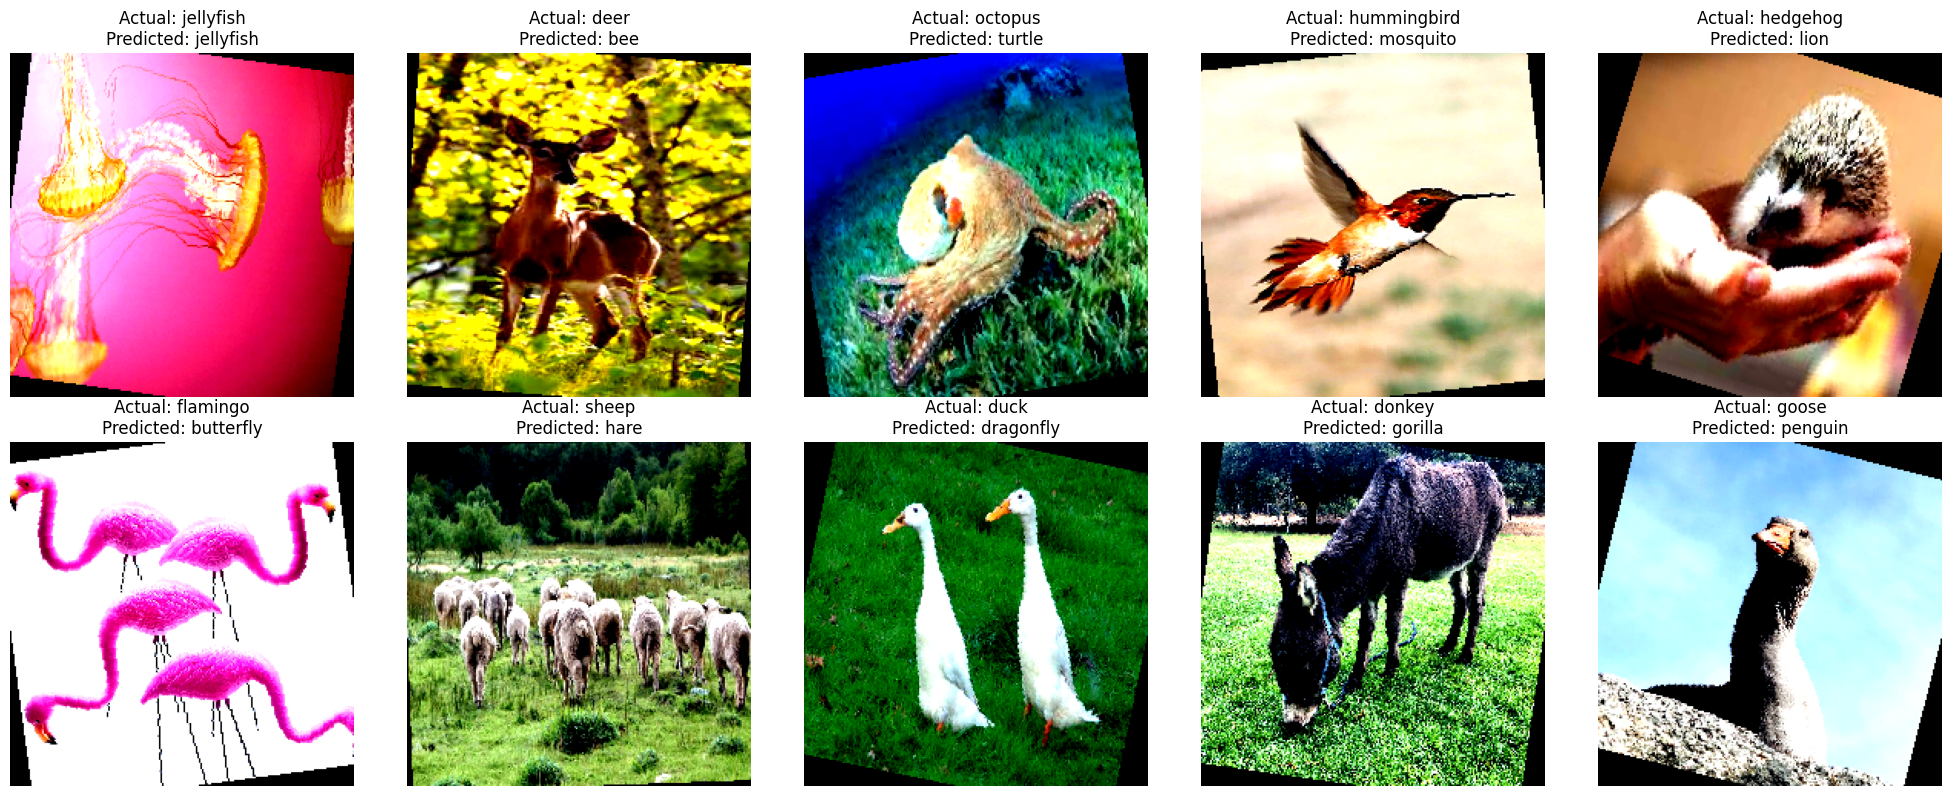

In [94]:
# Sample Predictions
def display_predictions(model, test_loader, num_samples=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = outputs.max(1)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        true_label = label_encoder.inverse_transform([labels[i].item()])[0]
        pred_label = label_encoder.inverse_transform([predicted[i].item()])[0]
        ax.set_title(f'Actual: {true_label}\nPredicted: {pred_label}')
    
    plt.tight_layout()
    plt.show()

display_predictions(model, test_loader)

# Please consider upvoting to show your support!